In [1]:
import cv2
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import matplotlib.pyplot as plt


In [2]:
model_path = "pb"
model = tf.saved_model.load(model_path)
movenet = model.signatures['serving_default']


In [3]:
LEFT_ELBOW_IDX = 7
RIGHT_ELBOW_IDX = 8


In [4]:
with open('./dataset/no_punch/puch_coordinates24.txt', 'w') as f:
    cap = cv2.VideoCapture('./fight/video4.mp4')

    while True:
        ret, frame = cap.read()

        if not ret:
            break

        frame_height, frame_width, _ = frame.shape
        image = tf.expand_dims(frame, axis=0)
        image = tf.cast(tf.image.resize_with_pad(
            image, 192, 192), dtype=tf.int32)
        outputs = movenet(image)
        keypoints = np.squeeze(outputs['output_0'])
        left_elbow_coords = None
        right_elbow_coords = None

        if keypoints.ndim == 2:
            if LEFT_ELBOW_IDX < keypoints.shape[0]:
                left_elbow_coords = (int(keypoints[LEFT_ELBOW_IDX][1] * frame_width), int(
                    keypoints[LEFT_ELBOW_IDX][0] * frame_height))
            if RIGHT_ELBOW_IDX < keypoints.shape[0]:
                right_elbow_coords = (int(keypoints[RIGHT_ELBOW_IDX][1] * frame_width), int(
                    keypoints[RIGHT_ELBOW_IDX][0] * frame_height))

        elif keypoints.ndim == 3:
            max_score_idx = np.argmax(keypoints[:, :, 2])
            if LEFT_ELBOW_IDX < keypoints.shape[1]:
                left_elbow_coords = (int(
                    keypoints[max_score_idx, LEFT_ELBOW_IDX][1] * frame_width), int(keypoints[max_score_idx, LEFT_ELBOW_IDX][0] * frame_height))
            if RIGHT_ELBOW_IDX < keypoints.shape[1]:
                right_elbow_coords = (int(
                    keypoints[max_score_idx, RIGHT_ELBOW_IDX][1] * frame_width), int(keypoints[max_score_idx, RIGHT_ELBOW_IDX][0] * frame_height))
                
        if left_elbow_coords is not None and right_elbow_coords is not None:
            f.write(f"{left_elbow_coords},{right_elbow_coords}\n")
    cap.release()


In [6]:
def plot_punch_dynamics(file_path):
    with open(file_path, 'r') as f:
        data = f.read()

    data = data.split('\n')
    x_l = [int(d.split(',')[0][1:]) for d in data[:-1]]
    y_l = [int(d.split(',')[1][1:-1]) for d in data[:-1]]
    x_r = [int(d.split(',')[2][1:]) for d in data[:-1]]
    y_r = [int(d.split(',')[3][1:-1]) for d in data[:-1]]

    dx_l = [x_l[i+1] - x_l[i] for i in range(len(x_l)-1)]
    dy_l = [y_l[i+1] - y_l[i] for i in range(len(y_l)-1)]
    dx_r = [x_r[i+1] - x_r[i] for i in range(len(x_r)-1)]
    dy_r = [y_r[i+1] - y_r[i] for i in range(len(y_r)-1)]
    plt.plot(dx_l, dy_l, label='Left Elbow')
    plt.plot(dx_r, dy_r, label='Right Elbow')

    plt.title('Punch Dynamics')
    plt.xlabel('Delta X')
    plt.ylabel('Delta Y')
    plt.legend()
    plt.show()


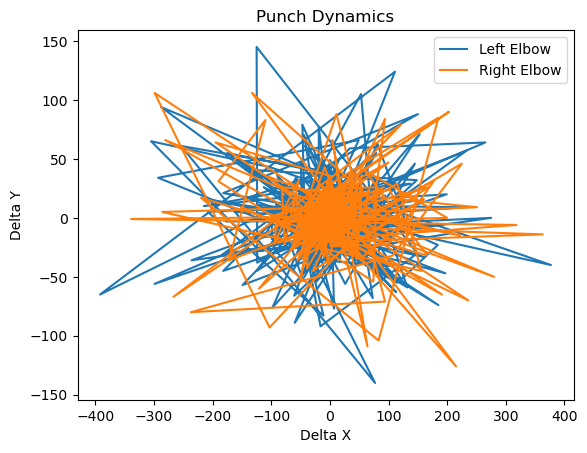

In [7]:
plot_punch_dynamics("./dataset/punch/puch_coordinates24.txt")


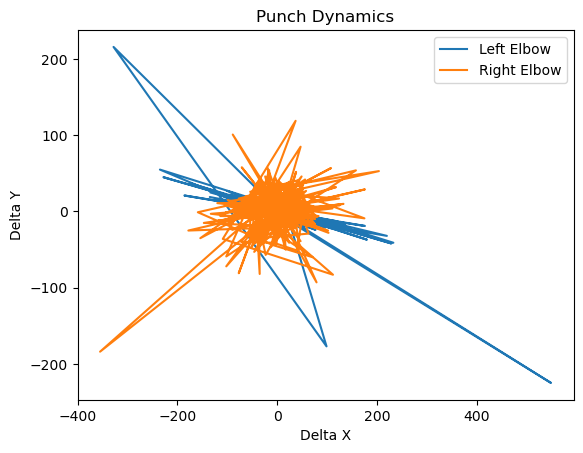

In [8]:
plot_punch_dynamics("./dataset/no_punch/puch_coordinates1.txt")


Graphs above represent vector change (delta) of elbow position by x,y- axis from the initial position. By using definitions of precision and variation, it can be predicted, that the 1st picture describes puch movements from video.mp4, while 2nd picture shows vectors in peaceful walk from video2.mp4

In [8]:
def plot_punch_dynamics2(file_path):
    with open(file_path, 'r', encoding='latin-1') as f:
        data = f.readlines()

    left_elbow_coords = []
    right_elbow_coords = []

    for line in data:
        coords = line.strip().split(',')
        left_elbow_coords.append(float(coords[0].strip('()')))
        right_elbow_coords.append(float(coords[1].strip('()')))

    x = np.linspace(0, len(left_elbow_coords), num=len(
        left_elbow_coords), endpoint=False)

    left_elbow_interp = np.interp(x, range(len(left_elbow_coords)), left_elbow_coords)
    right_elbow_interp = np.interp(
        x, range(len(right_elbow_coords)), right_elbow_coords)

    plt.plot(x, left_elbow_interp, label='Left elbow')
    plt.plot(x, right_elbow_interp, label='Right elbow')
    plt.legend()
    plt.xlabel('Frame number')
    plt.ylabel('Elbow coordinate')
    plt.title('Dynamics of the punch')
    plt.show()


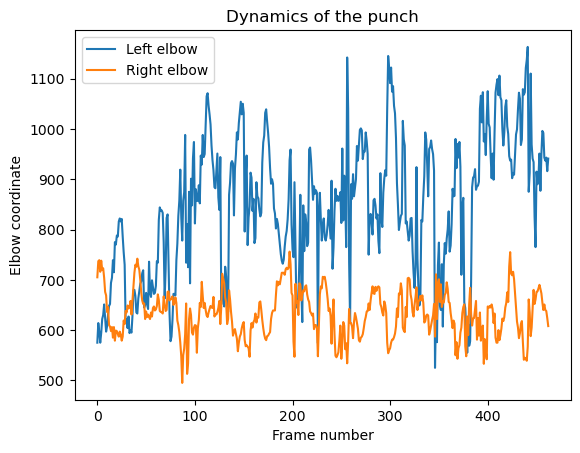

In [9]:
plot_punch_dynamics2("./dataset/punch/puch_coordinates24.txt")


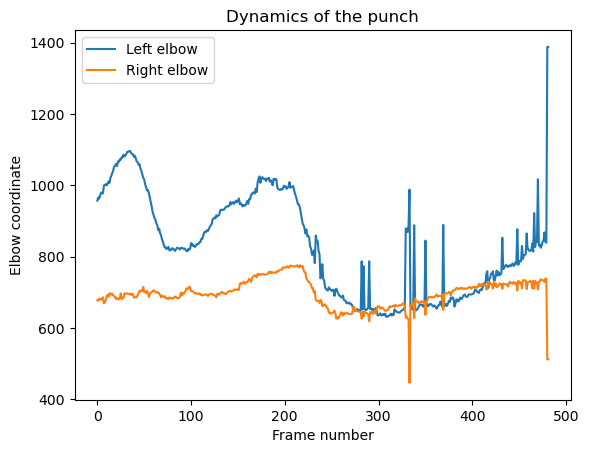

In [6]:
plot_punch_dynamics2("./dataset/no_punch/puch_coordinates1.txt")


Graphs above reveal dynamic change of position of coordinates. The use set of scalar values (points) by x and y axis to draw a general dynamics of elbow movement. 1st picture describes punch movement from video.mp4, 2nd picture uses video2.mp4 peaceful walk movements.

In [10]:
def plot_velocity_rate(doc_path):
    with open(doc_path, 'r') as f:
        data = f.read().splitlines()
    left_coords = []
    right_coords = []
    for d in data:
        l, r = d[1:-1].split('),(')
        left_coords.append([int(c) for c in l.split(',')])
        right_coords.append([int(c) for c in r.split(',')])
    left_velocities = np.diff(left_coords, axis=0)
    right_velocities = np.diff(right_coords, axis=0)

    left_accelerations = np.diff(left_velocities, axis=0)
    right_accelerations = np.diff(right_velocities, axis=0)

    left_accel_magnitudes = np.linalg.norm(left_accelerations, axis=1)
    right_accel_magnitudes = np.linalg.norm(right_accelerations, axis=1)

    fig, ax = plt.subplots()
    ax.plot(left_accel_magnitudes, label='Left elbow acceleration')
    ax.plot(right_accel_magnitudes, label='Right elbow acceleration')
    ax.legend()
    ax.set_xlabel('Time (frames)')
    ax.set_ylabel('Acceleration magnitude')
    ax.set_title('Rate of change of velocity of elbow coordinates over time')
    plt.show()


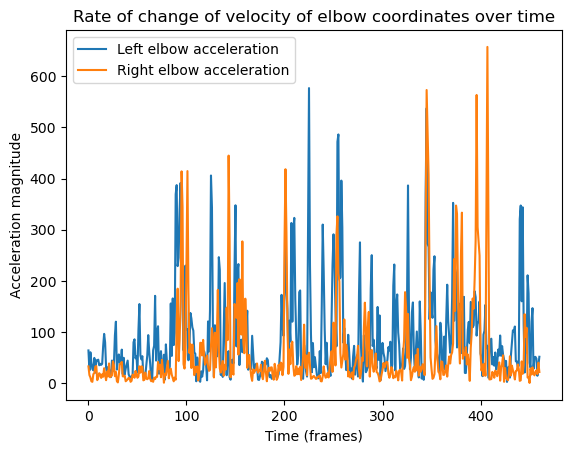

In [11]:
plot_velocity_rate("./dataset/punch/puch_coordinates24.txt")


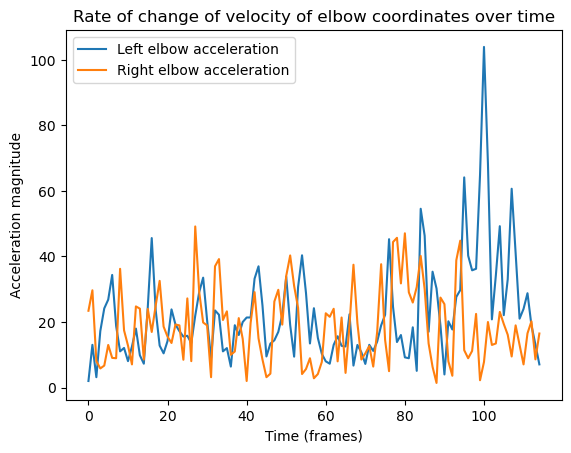

In [13]:
plot_velocity_rate("./dataset/no_punch/puch_coordinates2.txt")


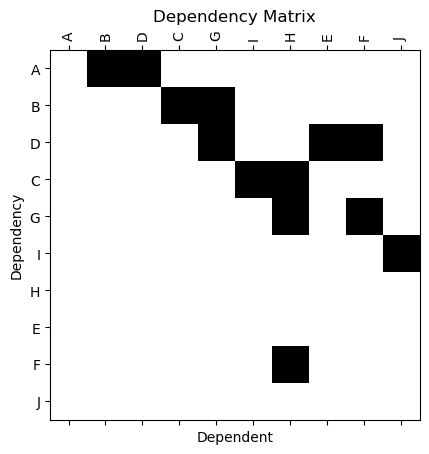

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Define the graph
graph = nx.DiGraph()
edges = [
    ('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'G'), ('C', 'I'),
    ('C', 'H'), ('D', 'E'), ('D', 'F'), ('D', 'G'), ('F', 'H'),
    ('G', 'F'), ('G', 'H'), ('I', 'J')
]
graph.add_edges_from(edges)

# Generate the adjacency matrix
dependency_matrix = nx.adjacency_matrix(graph).todense()

# Convert the matrix to 0s and 1s
dependency_matrix = np.where(dependency_matrix > 0, 1, 0)

# Draw the dependency matrix
fig, ax = plt.subplots()
ax.matshow(dependency_matrix, cmap='binary')

# Set the labels
labels = graph.nodes()
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels)

# Show the plot
plt.xlabel('Dependent')
plt.ylabel('Dependency')
plt.title('Dependency Matrix')
plt.show()


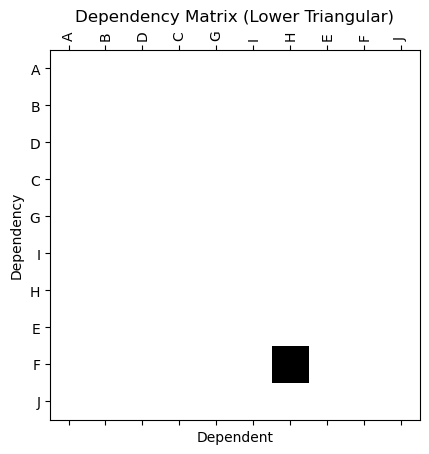

Updated Dependency Matrix (Lower Triangular):
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Define the graph
graph = nx.DiGraph()
edges = [
    ('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'G'), ('C', 'I'),
    ('C', 'H'), ('D', 'E'), ('D', 'F'), ('D', 'G'), ('F', 'H'),
    ('G', 'F'), ('G', 'H'), ('I', 'J')
]
graph.add_edges_from(edges)

# Generate the adjacency matrix
dependency_matrix = nx.adjacency_matrix(graph).todense()

# Convert the matrix to lower triangular
dependency_matrix = np.tril(dependency_matrix)

# Draw the dependency matrix
fig, ax = plt.subplots()
ax.matshow(dependency_matrix, cmap='binary')

# Set the labels
labels = graph.nodes()
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels)

# Show the plot
plt.xlabel('Dependent')
plt.ylabel('Dependency')
plt.title('Dependency Matrix (Lower Triangular)')
plt.show()

# Update the original matrix to be lower triangular
for i in range(len(dependency_matrix)):
    for j in range(i+1, len(dependency_matrix)):
        dependency_matrix[i, j] = 0

print("Updated Dependency Matrix (Lower Triangular):\n", dependency_matrix)


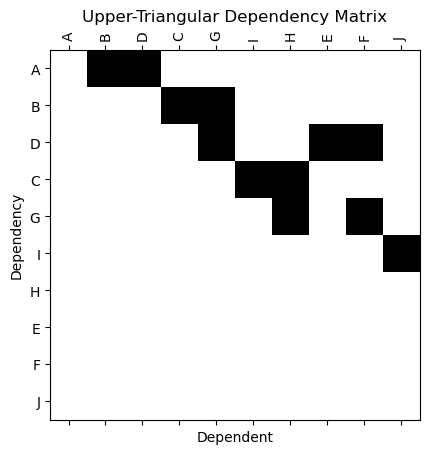

Updated Dependency Matrix:
[[0 1 1 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 1 0]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Define the graph
graph = nx.DiGraph()
edges = [
    ('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'G'), ('C', 'I'),
    ('C', 'H'), ('D', 'E'), ('D', 'F'), ('D', 'G'), ('F', 'H'),
    ('G', 'F'), ('G', 'H'), ('I', 'J')
]
graph.add_edges_from(edges)

# Generate the adjacency matrix
dependency_matrix = nx.adjacency_matrix(graph).todense()

# Convert the matrix to 0s and 1s
dependency_matrix = np.where(dependency_matrix > 0, 1, 0)

# Rearrange the matrix to become upper-triangular
dependency_matrix_upper = np.triu(dependency_matrix)

# Draw the dependency matrix
fig, ax = plt.subplots()
ax.matshow(dependency_matrix_upper, cmap='binary')

# Set the labels
labels = graph.nodes()
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels)

# Show the plot
plt.xlabel('Dependent')
plt.ylabel('Dependency')
plt.title('Upper-Triangular Dependency Matrix')
plt.show()

# Reflect the change in the copy of the original matrix
dependency_matrix[:] = dependency_matrix_upper

# Print the updated matrix
print("Updated Dependency Matrix:")
print(dependency_matrix)


In [12]:
import numpy as np

# Define the graph
graph = {
    'A': ['B', 'D'],
    'B': ['C', 'G'],
    'C': ['A', 'I', 'H'],
    'D': ['E', 'F', 'G'],
    'E': [],
    'F': ['H'],
    'G': ['F', 'H'],
    'H': [],
    'I': ['J'],
    'J': []
}

# Determine the order of matrix names
matrix_names = sorted(graph.keys())

# Initialize the dependency matrix
num_nodes = len(matrix_names)
dependency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

# Fill in the dependency matrix
for i, node in enumerate(matrix_names):
    for dependency in graph[node]:
        j = matrix_names.index(dependency)
        dependency_matrix[i, j] = 1

# Print the dependency matrix
print('Dependency Matrix:')
print('   ', end='')
for name in matrix_names:
    print(name, end=' ')
print()

for i, name in enumerate(matrix_names):
    print(name, end=' ')
    for j in range(num_nodes):
        print(dependency_matrix[i, j], end=' ')
    print()


Dependency Matrix:
   A B C D E F G H I J 
A 0 1 0 1 0 0 0 0 0 0 
B 0 0 1 0 0 0 1 0 0 0 
C 0 0 0 0 0 0 0 1 1 0 
D 0 0 0 0 1 1 1 0 0 0 
E 0 0 0 0 0 0 0 0 0 0 
F 0 0 0 0 0 0 0 1 0 0 
G 0 0 0 0 0 1 0 1 0 0 
H 0 0 0 0 0 0 0 0 0 0 
I 0 0 0 0 0 0 0 0 0 1 
J 0 0 0 0 0 0 0 0 0 0 
